In [132]:
%%time

import os
import boto3
import re
import io
import sagemaker
import pickle
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sagemaker.amazon.common as smac
import seaborn as sns
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer 
from sagemaker import get_execution_role
from textblob import TextBlob
from scipy import sparse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import dump_svmlight_file
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
role = get_execution_role()
region = boto3.Session().region_name

bucket='fakenewsdata' # put your s3 bucket name here, and create s3 bucket
prefix = 'sagemaker/DEMO-xgboost-regression'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

CPU times: user 45.9 ms, sys: 0 ns, total: 45.9 ms
Wall time: 326 ms


In [77]:
train=pd.read_csv('datasets/train.csv')

#data prep
train=train.fillna(' ')
train['total']=train['title']+' '+train['text']

#tfidf
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=10000)
counts = count_vectorizer.fit_transform(train['total'].values)
tfidf = transformer.fit_transform(counts)
targets = train['label'].values

In [102]:
# Save the count vectorizer voabulary to S3 so the transformer can be recreated in AWS Lambda preprocessor
vocab = count_vectorizer.vocabulary_
vocab = dict((k,int(v)) for k,v in vocab.items())
with open('data.json', 'w') as outfile:
    json.dump(vocab, outfile)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'vocab/vocab.json')).upload_file('data.json')

In [4]:
attributes = pd.DataFrame(tfidf.toarray())
targets = pd.DataFrame(targets)

In [5]:
#Split data into Training, Validation and Testing sets
X_train, X_test, y_train, y_test = train_test_split(attributes, targets, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train.copy(), y_train.copy(), test_size=0.2, random_state=1)

In [6]:
# Create CSV files with target values in the first column (XGBoost requirement)
pd.concat([y_train, X_train], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([y_val, X_val], axis=1).to_csv('validation.csv', index=False, header=False)

In [ ]:
data_check = pd.read_csv('validation.csv', delimiter=',')
data_check.head(10)

In [82]:
# Save CSVs to s3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [8]:
# Create container for XGBoost
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [9]:
# Filepaths for training and validation CSVs
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train/'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [10]:
# TRAIN MODEL

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                     role, 
                                     train_instance_count=1, 
                                     train_instance_type='ml.m4.xlarge',
                                     output_path='s3://{}/{}/output'.format(bucket, prefix),
                                     sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                         eta=0.2,
                         gamma=4,
                         min_child_weight=6,
                         subsample=0.8,
                         silent=0,
                         objective='binary:logistic',
                         num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2018-10-20-16-35-23-664


2018-10-20 16:35:23 Starting - Starting the training job...
2018-10-20 16:35:27 Starting - Launching requested ML instances......
2018-10-20 16:36:52 Starting - Preparing the instances for training......
2018-10-20 16:37:39 Downloading - Downloading input data...
2018-10-20 16:38:24 Training - Training image download completed. Training in progress..
Arguments: train
[2018-10-20:16:38:24:INFO] Running standalone xgboost training.
[2018-10-20:16:38:24:INFO] File size need to be processed in the node: 710.02mb. Available memory size in the node: 8549.73mb
[2018-10-20:16:38:24:INFO] Determined delimiter of CSV input is ','
[16:38:24] S3DistributionType set as FullyReplicated
[16:38:28] 13312x10000 matrix with 133120000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-10-20:16:38:28:INFO] Determined delimiter of CSV input is ','
[16:38:28] S3DistributionType set as FullyReplicated
[16:38:28] 3328x10000 matrix with 33280000 entries loaded from /opt/ml

[16:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max_depth=5
[39]#011train-error:0.02216#011validation-error:0.030349
[16:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=5
[40]#011train-error:0.021484#011validation-error:0.030048
[16:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=5
[41]#011train-error:0.020508#011validation-error:0.030048
[16:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=5
[42]#011train-error:0.020207#011validation-error:0.029748
[16:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=5
[43]#011train-error:0.020132#011validation-error:0.030349
[16:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=5
[44]#011train-error:0.020658#011valida

[16:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[87]#011train-error:0.008338#011validation-error:0.024038
[16:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[88]#011train-error:0.008338#011validation-error:0.024339
[16:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 6 pruned nodes, max_depth=5
[89]#011train-error:0.008113#011validation-error:0.024639
[16:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=5
[90]#011train-error:0.008113#011validation-error:0.024339
[16:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[91]#011train-error:0.007888#011validation-error:0.023438
[16:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=5
[92]#011train-error:0.007888#011vali

In [11]:
# Deploy model
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-10-20-16-45-59-094
INFO:sagemaker:Creating endpoint with name xgboost-2018-10-20-16-35-23-664


---------------------------------------------------------------------!

In [19]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

In [44]:
# Test model, splitting testing set into batches
def predict(data, rows=10):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(X_test[:1000].as_matrix())

In [45]:
# Display Model accuracy on testing set
accuracy_score(y_test[:1000], np.round(predictions))

0.977

In [ ]:
##################################################################
# The code below was used for data exploration and experimentation
##################################################################

In [103]:
df = pd.read_csv('datasets/fake.csv', usecols = ['author','title','text','language','site_url','country', 'spam_score'])
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,author,title,text,language,site_url,country,spam_score
0,NaN,Six former Soviet republics test air defenses ...,"Wed, 26 Oct 2016 19:33 UTC © Eduard Korniyenko...",english,sott.net,US,0.0
1,Starkman,WikiLeaks Expose Hillary Clinton’s Daytime Dri...,Hillary Clinton spent a whole afternoon drunk ...,english,topinfopost.com,US,0.0
2,Yves Smith,Links 11/10/16,Clinton didn’t lose because she’s a woman The ...,english,nakedcapitalism.com,US,0.0
3,pac522,,Part 2 Mother & Child Worship https://www.yout...,english,prisonplanet.com,US,0.0
4,NaN,Duterte Pulls a 180: China to Build Fake Islan...,Duterte Pulls a 180: China to Build Fake Islan...,english,blacklistednews.com,US,0.0


In [104]:
bin = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
category = pd.cut(df.spam_score, bins=bin, labels = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
category = category.to_frame()
category.columns = ['spam_category']
df_new = pd.concat([df,category],axis = 1)
df_new.head()

,author,title,text,language,site_url,country,spam_score,spam_category
0,NaN,Six former Soviet republics test air defenses ...,"Wed, 26 Oct 2016 19:33 UTC © Eduard Korniyenko...",english,sott.net,US,0.0,NaN
1,Starkman,WikiLeaks Expose Hillary Clinton’s Daytime Dri...,Hillary Clinton spent a whole afternoon drunk ...,english,topinfopost.com,US,0.0,NaN
2,Yves Smith,Links 11/10/16,Clinton didn’t lose because she’s a woman The ...,english,nakedcapitalism.com,US,0.0,NaN
3,pac522,,Part 2 Mother & Child Worship https://www.yout...,english,prisonplanet.com,US,0.0,NaN
4,NaN,Duterte Pulls a 180: China to Build Fake Islan...,Duterte Pulls a 180: China to Build Fake Islan...,english,blacklistednews.com,US,0.0,NaN


In [105]:
df_new = df_new[df_new.language == 'english']
df_new = df_new[df_new['text'].map(type) == str]
df_new['title'].fillna(value="", inplace=True)
df_new.dropna(axis=0, inplace=True, subset=['text', 'title', 'spam_category'])
# shuffle the data
df_new = df_new.sample(frac=1.0)
df_new.reset_index(drop=True,inplace=True)
df_new.head()

,author,title,text,language,site_url,country,spam_score,spam_category
0,NaN,Daily Mail forced to lie down in darkened room...,Tuesday 8 November 2016 Daily Mail forced to l...,english,newsthump.com,US,0.148,0.1
1,Victoria Taft,CNN Host Scolds Conway on Trump's Treatment of...,Share on Twitter \nDonald Trump's campaign man...,english,ijr.com,US,0.927,0.9
2,NaN,Humanity’s Greatest Mysteries - The Onion - Am...,Nation Puts 2016 Election Into Perspective By ...,english,theonion.com,US,0.173,0.1
3,NaN,Anonymous Just Issued a Message to the North D...,Anonymous Just Issued a Message to the North D...,english,theantimedia.org,US,0.600,0.5
4,Jhayla D. Tyson,7 Halloween Treats That Trick Children Into Cl...,It can be toilsome getting children into one c...,english,guardianlv.com,US,0.016,0.0


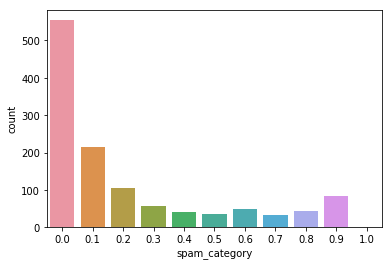

In [106]:
sns.countplot(df_new['spam_category'])

In [107]:
df_new['total']=df_new['title']+df_new['text']

display(type(df_new['total'][0]))

#tfidf
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1,1))
counts = count_vectorizer.fit_transform(df_new['total'].values)
tfidf = transformer.fit_transform(counts)
targets = df_new['spam_category'].values
targets = np.array(targets).reshape(-1,1)

display(tfidf.shape)
display(targets.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf, targets, random_state=0)

str

(1214, 30764)

(1214, 1)

In [108]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
print('Accuracy of Lasso classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Lasso classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Lasso classifier on training set: 1.00
Accuracy of Lasso classifier on test set: 0.43


In [109]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)
print('Accuracy of NB  classifier on training set: {:.2f}'
     .format(NB.score(X_train, y_train)))
print('Accuracy of NB classifier on test set: {:.2f}'
     .format(NB.score(X_test, y_test)))

Accuracy of NB  classifier on training set: 0.46
Accuracy of NB classifier on test set: 0.44


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [110]:
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)

Extr = ExtraTreesClassifier(n_estimators=5,n_jobs=4)
Extr.fit(X_train, y_train)
print('Accuracy of ExtrTrees classifier on training set: {:.2f}'
     .format(Extr.score(X_train, y_train)))
print('Accuracy of Extratrees classifier on test set: {:.2f}'
     .format(Extr.score(X_test, y_test)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy of ExtrTrees classifier on training set: 1.00
Accuracy of Extratrees classifier on test set: 0.40


In [111]:
from sklearn.tree import DecisionTreeClassifier

Adab= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(X_train, y_train)
print('Accuracy of Adaboost classifier on training set: {:.2f}'
     .format(Adab.score(X_train, y_train)))
print('Accuracy of Adaboost classifier on test set: {:.2f}'
     .format(Adab.score(X_test, y_test)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Adaboost classifier on training set: 0.52
Accuracy of Adaboost classifier on test set: 0.43


In [112]:
Rando= RandomForestClassifier(n_estimators=5)

Rando.fit(X_train, y_train)
print('Accuracy of randomforest classifier on training set: {:.2f}'
     .format(Rando.score(X_train, y_train)))
print('Accuracy of randomforest classifier on test set: {:.2f}'
     .format(Rando.score(X_test, y_test)))

Accuracy of randomforest classifier on training set: 0.91
Accuracy of randomforest classifier on test set: 0.42


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [113]:
bbc =  'Saudi Arabia Says Jamal Khashoggi Was Killed in Consulate Fight\n" + "Advertisement\nSupported by\nBy Ben Hubbard\nBEIRUT, Lebanon — After two weeks of shifting stories, Saudi Arabia said Saturday that its agents strangled Jamal Khashoggi, a dissident journalist, after a fistfight inside the Saudi Consulate in Istanbul and that 18 men had been arrested in the case.\nThose arrested included 15 men who were sent to confront Mr. Khashoggi, plus one driver and two consular staff, a Saudi official said.\nState media reported that Saud al-Qahtani, a close aide to the crown prince, had been dismissed, along with Maj. Gen. Ahmed al-Assiri, the deputy director of Saudi intelligence, and other high-ranking intelligence officials. The Saudi official said General Asiri had organized the operation and that Mr. Qahtani had known about it and contributed to the aggressive environment that allowed it to escalate into violence.\nPresident Trump on Friday night said that Saudi Arabia’s acknowledgment of the death and its announcement of arrests were “good first steps” but said he would consider “some form of sanction” in retaliation.\nSince Mr. Khashoggi disappeared after entering the consulate on Oct. 2, Saudi Arabia has offered various, changing explanations for his disappearance — initially claiming that he had left the consulate alive.\nBut international outrage mounted as Turkish officials leaked lurid details from their own investigation suggesting that he was murdered inside the consulate and dismembered by a team of 15 Saudi agents who flew in specifically to kill him.\nThe case has battered the international reputation of the kingdom and its 33-year-old crown prince, Mohammed bin Salman, who has sought to sell himself to the world as a young reformer shaking off his country’s conservative past. But suspicions that such a complicated foreign operation could not have been launched without at least his tacit approval have driven away many of his staunchest foreign supporters.\nBig name chief executives, investors and foreign officials, including Treasury Secretary Steven Mnuchin, have dropped out of a Saudi investment conference that the crown prince is hosting in Riyadh next week.\nThe Trump administration had built strong ties with Crown Prince Mohammed, seeing him as a strong partner in its ambitions to counter Iran, forge a deal between Israel and the Palestinians, and reconfigure the Middle East. Although Mr. Trump said he would consider sanctions, he said he “would prefer we don’t use as retribution” the cancellation of $110 billion worth of arms sales to Saudi Arabia.\nFor the first time on Saturday, a Saudi official familiar with the government’s handling of the situation put forward the kingdom’s narrative of the events that led to Mr. Khashoggi’s death.\nSpeaking on condition of anonymity because the investigation was continuing, the official said that the kingdom had a general order to get dissidents living abroad to return to the kingdom. When the consulate in Istanbul reported that Mr. Khashoggi would be coming in on Oct. 2 to pick up a document needed for his upcoming marriage, General Asiri dispatched a 15-man team to confront him.\nThe team included Maher Abdulaziz Mutrib, a security officer identified by The New York Times this week as a frequent member of the crown prince’s security detail during foreign trips, the official said. Mr. Mutrib had been chosen because he had worked with Mr. Khashoggi a decade ago in the Saudi Embassy in London and knew him personally.\nBut the order to return Mr. Khashoggi to the kingdom was misinterpreted as it made its way down the chain of command, the official said, and a confrontation ensued as soon as Mr. Khashoggi saw the men. He tried to flee, the men stopped him, punches were thrown, Mr. Khashoggi screamed and one of the men put him in a chokehold, strangling him to death, the official said.\n“The interaction in the room didn’t last very long at all,” the official said.\nThe team then gave the body to a local collaborator to dispose of, meaning that they do not know where it ended up, and returned to the kingdom, the official said.\nAll 15 members of the team had been identified by name by the Turks, and Turkish newspapers had published their photographs. The New York Times established that most of them were employed by the Saudi military or security services and that at least four had traveled with the crown prince as part of his security detail.\nThe Turks had said the body had been disassembled with a bone saw by an autopsy specialist flown in specifically for that purpose and probably carried out of the consulate in large suitcases.\nTurkish investigators were searching a park and a forest for traces of Mr. Khashoggi’s remains this week but did not announce their findings.\nThe reports of Mr. Khashoggi’s killing had shaken members of the Saudi royal family, many of whom were angry about Crown Prince Mohammed’s swift rise over the past three years. Some wondered if the scandal could lead his father, King Salman, to replace him with another prince not tarnished by the case.\nBut instead, the king named Crown Prince Mohammed the head of a committee to restructure the kingdom’s intelligence agency.\nPeople with knowledge of the Saudi plans had told The Times on Thursday that the kingdom was planning to blame the operation on General Assiri, the deputy intelligence director. The people said the kingdom would portray the operation as carried out by rogue actors who did not have orders from the top and who had set out to interrogate and kidnap Mr. Khashoggi but ended up killing him, perhaps accidentally.\nThe dismissal of Mr. Qahtani, considered one of the two closest aides to Crown Prince Mohammed, stood out because he is plays no public role in security or intelligence. He is in charge of media and communications for the crown prince, and he is widely believed to direct large-scale social media campaigns in support of him.\nThe Saudi official said Mr. Qahtani had been fired because he had known about the operation and had contributed to the aggressive environment that allowed it to turn violent. Many social media accounts supportive of Prince Mohammed have systematically disparaged Mr. Khashoggi since his disappearance.\nMr. Khashoggi, 60, was one of Saudi Arabia’s best known personalities, a journalist who had interviewed Osama bin Laden in Afghanistan years before he founded Al Qaeda. He later served an adviser to and unofficial spokesman for the Saudi royal family.\nBut his relationship with the kingdom changed during the rise of Crown Prince Mohammed, who has announced broad social and economic reforms but has also gone after critics and cut down many of his fellow royals.\nAfter many of his friends and colleagues were jailed last year, Mr. Khashoggi settled into self-exile in the Washington area and became a columnist for The Washington Post, a position he used to criticize the crown prince’s increasing authoritarianism.\nMr. Khashoggi entered the Saudi Consulate in Istanbul on Oct. 2 to pick up an official document he needed to marry his Turkish fiancée, Hatice Cengiz. When he didn’t come out after a number of hours, Ms. Cengiz began calling Turkish officials to tell them that Mr. Khashoggi was missing.\nSaudi Arabia chose to make its announcement in the middle of the night over a weekend in Riyadh and Istanbul. A Turkish official said it was too soon for Ankara to comment, but reaction on social media and elsewhere was dismissive.\nRepresentative Adam Schiff of California, the senior Democrat on the House Intelligence Committee, said Friday night that he had received a detailed, classified briefing earlier in the day on what American spy services believe were the circumstances surrounding Mr. Khashoggi’s killing and who was responsible.\nIn a telephone interview, Mr. Schiff would not disclose what intelligence agency briefers told him, citing its classified nature. But when asked whether his briefing was consistent with the explanation the Saudi government issued Saturday, Mr. Schiff said the Saudi version “was not credible.”\n“The kingdom and all involved in this brutal murder must be held accountable, and if the Trump administration will not take the lead, Congress must,” he said.\nSamantha Power, a former ambassador to the United Nations under President Barack Obama, said on Twitter that the Saudis were “shifting from bald-face lies (‘#Khashoggi left consulate’) to faux condemnation (of a ‘rogue operation’) to claiming the fox will credibly investigate what he did to the hen.”\nBut Ali Shihabi, the founder of the Arabia Foundation in Washington and a prominent advocate for the kingdom’s policies, defended the belated statement, arguing that an initial cover-up that hid the truth from the royal court explained the delay.\n“Part of the reason for firing so many top intelligence officials was due to the cover-up and slowness in conveying the full details of what happened to the leadership,” he wrote on Twitter. “This tragic fiasco was a huge shock to the Saudi leadership and a combination of confusion, lack of experience in such crisis management and a cover-up by the intelligence bureaucracy contributed to the initial Saudi response.”\nJon B. Alterman, director of the Middle East Program at the Center for Strategic and International Studies, said the Saudis will have to provide more information — which may or may not comport with the intelligence that Turkey and the United States have gathered over the past two weeks.\n“This has to be the beginning of a multiday effort that is long overdue,” Mr. Alterman said.\nThe Saudi statement, for example, offered no explanation for why Mr. Khashoggi might enter an altercation with multiple foes in territory he knew to be dangerous. Mr. Khashoggi was regarded as low key and even-tempered by those who knew him. He felt nervous enough about his safety entering the consulate that he told his fiancée to wait outside with instructions to call the Turkish authorities if he did not emerge.\nWhether the United States or Turkey is willing to dispute or contradict the Saudi explanation is far from clear. The Saudi narrative seemed to dodge the question of whether the men had been acting at the direction of top officials.\nThe Trump administration has spent weeks trying to salvage Saudi Arabia’s role in its strategy to isolate Iran, which will be punctuated by the Nov. 5 re-imposition of onerous sanctions lifted under the 2015 Iran nuclear accord.\nThe Turkish government has said it has audio and video recordings that suggest the Saudis ambushed Mr. Khoshoggi in the consulate and dismembered him. But President Recep Tayyip Erdogan of Turkey may never reveal these recordings.\nElliott Abrams, a former top diplomat in Republican administrations, said the Saudi acknowledgment was an important first step but that many questions remain unanswered.\n“Where is Jamal Khashoggi’s body, for one?” Mr. Abrams asked. “And it’s just hard to believe these people acted without instructions.”\nMr. Abrams also dismissed the core of the Saudi explanation that Mr. Khashoggi had decided to put up a fight.\n“He’s in the consulate surrounded by a crowd of men and he starts a fight?” Mr. Abrams asked. “It’s just not credible.”\nDavid D. Kirkpatrick contributed reporting from London, Eric Schmitt and Gardiner Harris from Washington, and Emily Cochrane from Glendale, Ariz.\nvideo\nAdvertisement\n'
bbc = [bbc]

In [114]:

bbc_c = count_vectorizer.transform(bbc)
bbc_t = transformer.transform(bbc_c)

y = Rando.predict(bbc_t)

display(y)
y

array(['0.0'], dtype=object)

array(['0.0'], dtype=object)

In [115]:
fake_title = 'Is Barron Trump a Chess Grandmaster?'
fake_text = 'The tweets pushing this iubsreijv . vwcoiqh weoivehv vqiohe vcoH VO ehhuughghuuhgruhuhgruh ValueErrorV ROJH QVOI ROIV ROI VEJ VOERJ VOIJ OIRJVOW4IEJV OIQWV OIREV OIRE VOIER rumor also made several other outlandish claims: Some held that Barron Trump had an IQ of 146; others maintained that Barron’s father Donald Trump studied under chess legend Bobby Fischer and was himself one of the most celebrated chess players of all time. Many of these tweets were also accompanied by the accusation that the mainstream news media was ignoring the many chess-related accomplishments of the Trump family. While it’s true that mainstream news has largely ignored these stories, that circumstance isn’t due to any perceived bias. These reports were left uncovered for the simple fact that they were untrue. Everyone knows Barron Trump is the smartest President’s kid ever. Or should we call him First Son? Either way, Barron has been awarded the prestigious title of Chess Grandmaster this week from the International Board of Chessmasters … This should be no surprise considering who is father is. Donald Trump is one of the highest ranked and most celebrated American chess players of all time. In the 1970s and 80s, Donald Trump studied under the tutelage of players like Bobby Fischer. Eventually, he won hundreds of chess tournaments abroad before retiring at the ripe old age of 40.'
fake = fake_title + ' ' + fake_text
fake = [fake]

In [116]:
fake_c = count_vectorizer.transform(fake)
fake_t = transformer.transform(fake_c)

y = Rando.predict(fake_t)

display(y)

array(['0.0'], dtype=object)

In [117]:
# log_reg = LogisticRegression()
# display(X_train.shape)
# display(y_train.shape)
# log_reg.fit(X_train, y_train)


# print('The Coefficient of Determination is : ' + str(r2_score(y, y_cross_val)))
# print('The Root Mean Squared Error is : ' + str(sqrt(mean_squared_error(y, y_cross_val))))

In [118]:
train=pd.read_csv('datasets/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
id        20800 non-null int64
title     20242 non-null object
author    18843 non-null object
text      20761 non-null object
label     20800 non-null int64
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [121]:
#data prep
train=train.fillna(' ')
train['total']=train['title']+' '+train['text']

#tfidf
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
counts = count_vectorizer.fit_transform(train['total'].values)
tfidf = transformer.fit_transform(counts)

In [122]:
targets = train['label'].values

In [123]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, targets, random_state=0)

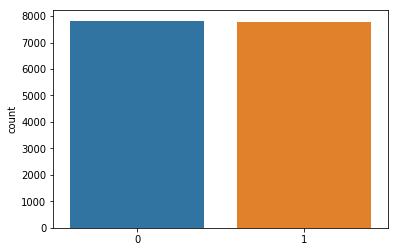

In [124]:
sns.countplot(y_train)

In [125]:
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)

Extr = ExtraTreesClassifier(n_estimators=5,n_jobs=4)
Extr.fit(X_train, y_train)
print('Accuracy of ExtrTrees classifier on training set: {:.2f}'
     .format(Extr.score(X_train, y_train)))
print('Accuracy of Extratrees classifier on test set: {:.2f}'
     .format(Extr.score(X_test, y_test)))

Accuracy of ExtrTrees classifier on training set: 1.00
Accuracy of Extratrees classifier on test set: 0.84


In [126]:
Adab= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(X_train, y_train)
print('Accuracy of Adaboost classifier on training set: {:.2f}'
     .format(Adab.score(X_train, y_train)))
print('Accuracy of Adaboost classifier on test set: {:.2f}'
     .format(Adab.score(X_test, y_test)))

Accuracy of Adaboost classifier on training set: 0.95
Accuracy of Adaboost classifier on test set: 0.95


In [127]:
Rando= RandomForestClassifier(n_estimators=5)

Rando.fit(X_train, y_train)
print('Accuracy of randomforest classifier on training set: {:.2f}'
     .format(Rando.score(X_train, y_train)))
print('Accuracy of randomforest classifier on test set: {:.2f}'
     .format(Rando.score(X_test, y_test)))

Accuracy of randomforest classifier on training set: 0.98
Accuracy of randomforest classifier on test set: 0.81


In [128]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
print('Accuracy of Lasso classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Lasso classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Lasso classifier on training set: 1.00
Accuracy of Lasso classifier on test set: 0.98


In [129]:
display(bbc)

['Saudi Arabia Says Jamal Khashoggi Was Killed in Consulate Fight\n" + "Advertisement\nSupported by\nBy Ben Hubbard\nBEIRUT, Lebanon — After two weeks of shifting stories, Saudi Arabia said Saturday that its agents strangled Jamal Khashoggi, a dissident journalist, after a fistfight inside the Saudi Consulate in Istanbul and that 18 men had been arrested in the case.\nThose arrested included 15 men who were sent to confront Mr. Khashoggi, plus one driver and two consular staff, a Saudi official said.\nState media reported that Saud al-Qahtani, a close aide to the crown prince, had been dismissed, along with Maj. Gen. Ahmed al-Assiri, the deputy director of Saudi intelligence, and other high-ranking intelligence officials. The Saudi official said General Asiri had organized the operation and that Mr. Qahtani had known about it and contributed to the aggressive environment that allowed it to escalate into violence.\nPresident Trump on Friday night said that Saudi Arabia’s acknowledgment 

In [130]:
bbc_c = count_vectorizer.transform(bbc)
bbc_t = transformer.transform(bbc_c)

y = logreg.predict(bbc_t)

display(y)
y

array([0])

array([0])

In [131]:
fake_c = count_vectorizer.transform(fake)
fake_t = transformer.transform(fake_c)

y = logreg.predict(fake_t)

display(y)

array([1])